# Часть первая

In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
env = gym.make('Blackjack-v0', natural=True)
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


States: (32\*10\*2 array):

    Players current sum: [0,31] i.e. 32 states
    Dealer’s face up card: [1,10] i.e. 10 states
    Whether the player has a usable ace or not: [0] or [1] i.e. 2 states
    
Actions:

    Either stick or hit: [0] or [1] i.e 0 for stick , 1 for hit

## 1.
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [3]:
env_actions = {0: "Stick", 1: "Hit"}
def make_step(env, action):
    next_state, reward, done, info = env.step(action)
    return next_state, reward, done, info

In [4]:
def make_step(env, action):
    next_state, reward, done, info = env.step(action)
    return next_state, reward, done, info
    
def generate_episode_from_my_policy(env, only_reward=False):
    """Генерирую эпизод игры по собственной стратегии"""
    episode = []
    state = env.reset()
    while True:
        action = 0 if state[0] >= 19 else 1
        next_state, reward, done, info = make_step(env, action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    if only_reward:
        return episode[-1][2]
    states, actions, rewards = zip(*episode)
    rewards = np.array(rewards)
    return states, actions, rewards

In [5]:
def play_n_episodes(episode_generator, n_episodes=100000):
    """Считаю получившуюся награду за n эпизодов игры"""
    rewards = np.array([episode_generator() for _ in range(n_episodes)])
    return np.mean(rewards), n_episodes

In [6]:
for i in range(5):
    print(generate_episode_from_my_policy(env))

(((13, 6, False),), (1,), array([-1.]))
(((19, 4, False),), (0,), array([1.]))
(((15, 4, False), (18, 4, False)), (1, 1), array([ 0., -1.]))
(((18, 6, False),), (1,), array([-1.]))
(((13, 8, False),), (1,), array([-1.]))


Сыграем 100000 эпизодов игры и посмотрим на средний выигрыш

In [7]:
play_n_episodes(episode_generator=lambda : generate_episode_from_my_policy(env, only_reward=True), n_episodes=100000)

(-0.173565, 100000)

Алгоритм: First-Visit Monte Carlo Prediction (for action values)

![MonteCarlo_prediction_Q.png](MonteCarlo_prediction_Q.png)
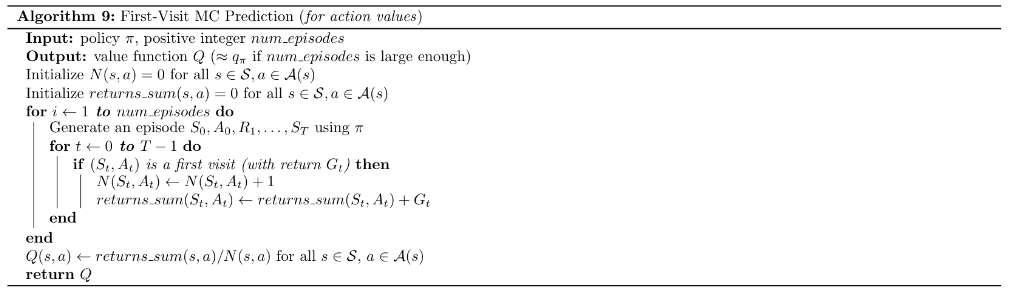

In [8]:
def calculate_G(rewards, gamma):
    n = rewards.shape[0]
    G = np.zeros(n + 1)
    for i in range(n - 1, -1, -1):
        G[i] = rewards[i] + gamma * G[i + 1]
    return G[:n]
    
def mc_prediction_q(env, num_episodes, episode_generator, gamma=1.0):
    # ключ у следующих словарей - это состояние
    Q = defaultdict(lambda: np.zeros(len(env_actions)))
    N = defaultdict(lambda: np.zeros(len(env_actions)))
    returns_sum = defaultdict(lambda: np.zeros(len(env_actions)))
    for episode in tqdm(range(1, num_episodes + 1)):
        states, actions, rewards = episode_generator()
        visited_s_a = set()  # first-visit MC
        # предпосчитаю G
        G = calculate_G(rewards, gamma)
        for i, state in enumerate(states):
            if (state, actions[i]) not in visited_s_a:  # first-visit MC
                N[state][actions[i]] += 1.0
                returns_sum[state][actions[i]] += G[i]
                visited_s_a.add((state, actions[i]))  # запомню что посетил
                Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [9]:
Q = mc_prediction_q(env, 500000, lambda:generate_episode_from_my_policy(env), gamma=0.995)

Визуализируем Value function

In [10]:
def plot_V_function(V):
    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([V[x, y, usable_ace] for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, vmin=-3.0, vmax=3.0)
        ax.set_xlabel('Players current sum')
        ax.set_ylabel('Dealer’s face up card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

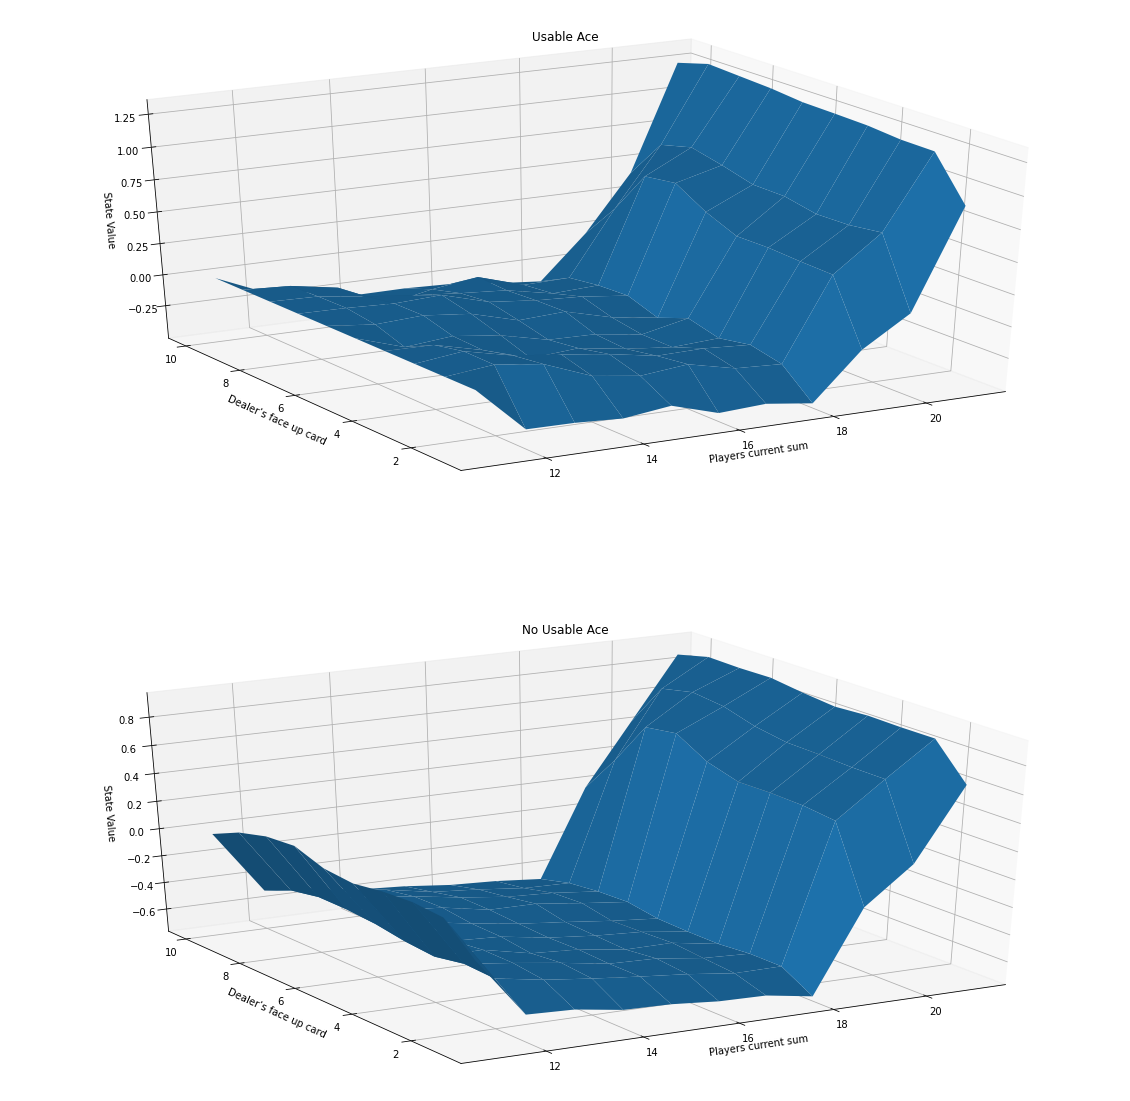

In [11]:
# V(s) = Q(s, π(s))
V = defaultdict(lambda:0, dict((k,v[0] if k[0] > 18 else v[1]) for k, v in Q.items()))

plot_V_function(V)  

## 2.
Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Алгоритм: First-Visit Monte Carlo Control (for action values)

![MonteCarlo_control.png](MonteCarlo_control.png)
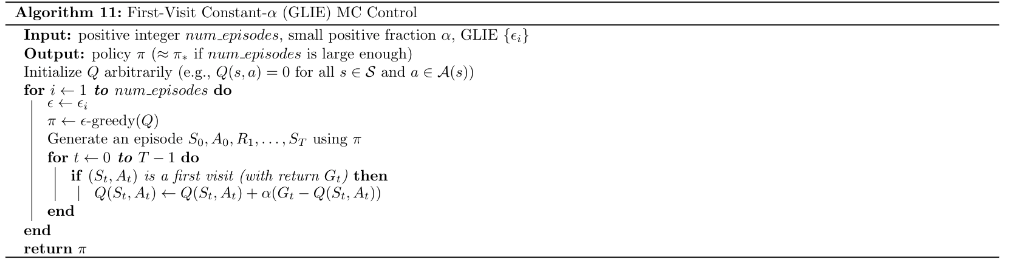

In [12]:
def take_action_by_epsilon_greedy_pi(Q_s, state_in_Q, epsilon):
    if state_in_Q:
        epsilon_greedy_pi = np.ones(len(env_actions)) * epsilon / len(env_actions)
        best_a = np.argmax(Q_s)
        epsilon_greedy_pi[best_a] = 1 - epsilon + (epsilon / len(env_actions))
    else:
        epsilon_greedy_pi = np.ones(len(env_actions)) / len(env_actions)  # равномерное распределение
    action = np.random.choice(np.arange(len(env_actions)), p=epsilon_greedy_pi)
    return action
  
def generate_episode_from_Q(env, Q, epsilon, only_reward=False):
    episode = []
    state = env.reset()
    while True:
        action = take_action_by_epsilon_greedy_pi(Q[state], state in Q, epsilon)
        next_state, reward, done, info = make_step(env, action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    if only_reward:
        return episode[-1][2]
    states, actions, rewards = zip(*episode)
    rewards = np.array(rewards)
    return states, actions, rewards

In [13]:
def mc_control(env, num_episodes, alpha, gamma=1.0, init_Q=None, eps_start=1.0, eps_decay=.99999, eps_min=0.005,
               n_episodes=100000, verbose=10):
    if init_Q is None:
        Q = defaultdict(lambda: np.zeros(len(env_actions)))
    else:
        Q = init_Q
    sum_rewards = []
    epsilon = eps_start
    verbose_episodes = num_episodes // verbose if verbose != 0 else num_episodes + 1
    with tqdm(file=sys.stdout) as pbar:
        for episode in tqdm(range(1, num_episodes + 1)):
            # изменяю эпсилон в ходе обучения
            epsilon = max(epsilon * eps_decay, eps_min)
            if episode % verbose_episodes == 0 or episode == 1:
                mean_sum_reward, n_episodes = \
                    play_n_episodes(episode_generator=lambda:generate_episode_from_Q(env, Q, epsilon=0.0, only_reward=True), n_episodes=n_episodes)
                sum_rewards.append((episode, mean_sum_reward, n_episodes))
                pbar.write(f"Episode = {episode} Epsilon = {epsilon} Mean_sum_reward = {mean_sum_reward} n_episode = {n_episodes}")   
#                 pbar.set_description(f"Episode = {episode} Epsilon = {epsilon}")
                pbar.update(1)
            states, actions, rewards = generate_episode_from_Q(env, Q, epsilon)
            visited_s_a = set()  # first-visit MC
            # предпосчитаю G
            G = calculate_G(rewards, gamma)
            for i, state in enumerate(states):
                if (state, actions[i]) not in visited_s_a:  # first-visit MC
                    old_Q = Q[state][actions[i]] 
                    Q[state][actions[i]] = old_Q + alpha * (G[i] - old_Q)
                    visited_s_a.add((state, actions[i]))  # запомню что посетил
    # в состояниях где агент не был - не берем больше карт
    policy = defaultdict(lambda: 1, dict((k, np.argmax(v)) for k, v in Q.items()))
    return policy, Q, sum_rewards

In [14]:
policy, Q, sum_rewards = mc_control(env, 500000, alpha=0.003, gamma=0.99995, n_episodes=100000)

Episode = 1 Epsilon = 0.99999 Mean_sum_reward = -0.16804 n_episode = 100000
Episode = 50000 Epsilon = 0.606529143379149 Mean_sum_reward = -0.0656 n_episode = 100000
Episode = 100000 Epsilon = 0.3678776017682482 Mean_sum_reward = -0.05752 n_episode = 100000
Episode = 150000 Epsilon = 0.2231284866688706 Mean_sum_reward = -0.03812 n_episode = 100000
Episode = 200000 Epsilon = 0.13533392988275578 Mean_sum_reward = -0.041935 n_episode = 100000
Episode = 250000 Epsilon = 0.08208397256192254 Mean_sum_reward = -0.044425 n_episode = 100000
Episode = 300000 Epsilon = 0.04978632156314083 Mean_sum_reward = -0.03268 n_episode = 100000
Episode = 350000 Epsilon = 0.03019685496969085 Mean_sum_reward = -0.03043 n_episode = 100000
Episode = 400000 Epsilon = 0.01831527257751119 Mean_sum_reward = -0.030955 n_episode = 100000
Episode = 450000 Epsilon = 0.011108746587193668 Mean_sum_reward = -0.02806 n_episode = 100000
Episode = 500000 Epsilon = 0.006737778551546669 Mean_sum_reward = -0.033995 n_episode = 1

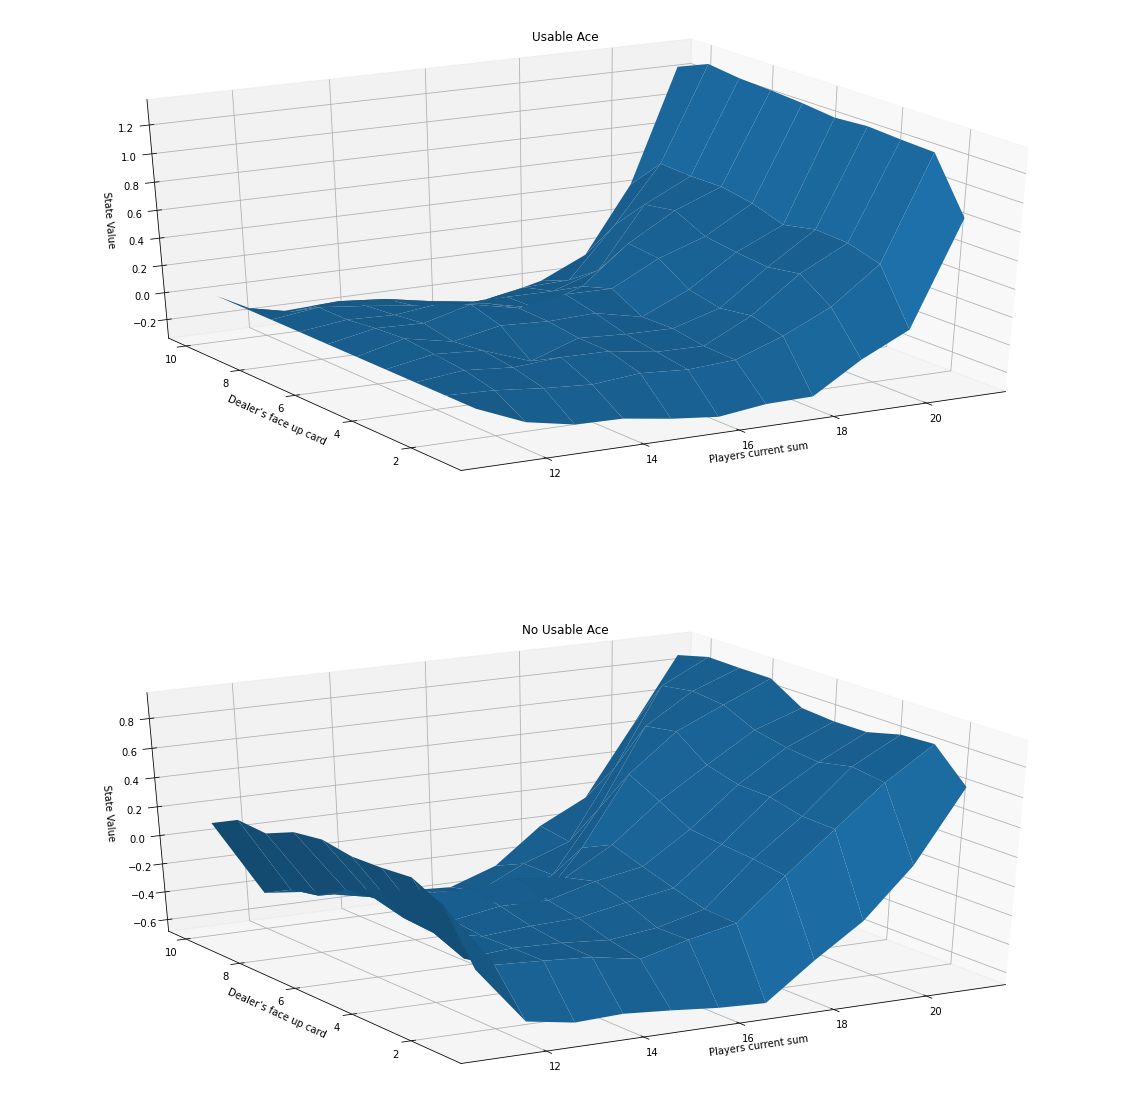

In [15]:
# V(s) = Q(s, π(s))
V = defaultdict(lambda:0, dict((k, np.max(v)) for k, v in Q.items()))

plot_V_function(V)

Сыграем 100000 эпизодов игры и посмотрим на средний выигрыш

In [16]:
play_n_episodes(episode_generator=lambda:generate_episode_from_Q(env, Q, epsilon=0.0, only_reward=True), n_episodes=100000)

(-0.022685, 100000)

Можем визуализировать полученную стратегию

In [17]:
def plot_policy(policy):

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[policy[x,y,usable_ace] for x in x_range] for y in y_range])
        surf = ax.imshow(Z, vmin=0, vmax=max(list(env_actions.keys())), extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Players current sum')
        ax.set_ylabel('Dealer’s face up card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=list(env_actions.keys()), cax=cax)
        cbar.ax.set_yticklabels([f"{k} ({v})" for k, v in env_actions.items()])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

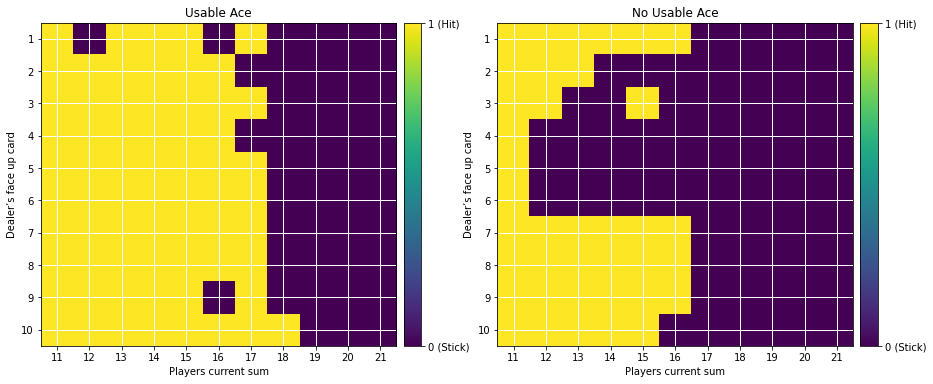

In [18]:
plot_policy(policy)

## 3.
Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Визуализируем доходность стартегии в ходе обучения

In [19]:
def plot_sum_reward(sum_rewards):
    _, _, n_episodes = sum_rewards[0]
    episodes, mean_sum_rewards, _,= zip(*sum_rewards)
    x = episodes
    y = mean_sum_rewards
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    ax.plot(x, y)
    ax.set_title(f"Mean sum rewards during learning: n_episodes = {n_episodes}")
    ax.set_xlabel('Episode')
    ax.set_ylabel('Sum reward')
    plt.show()

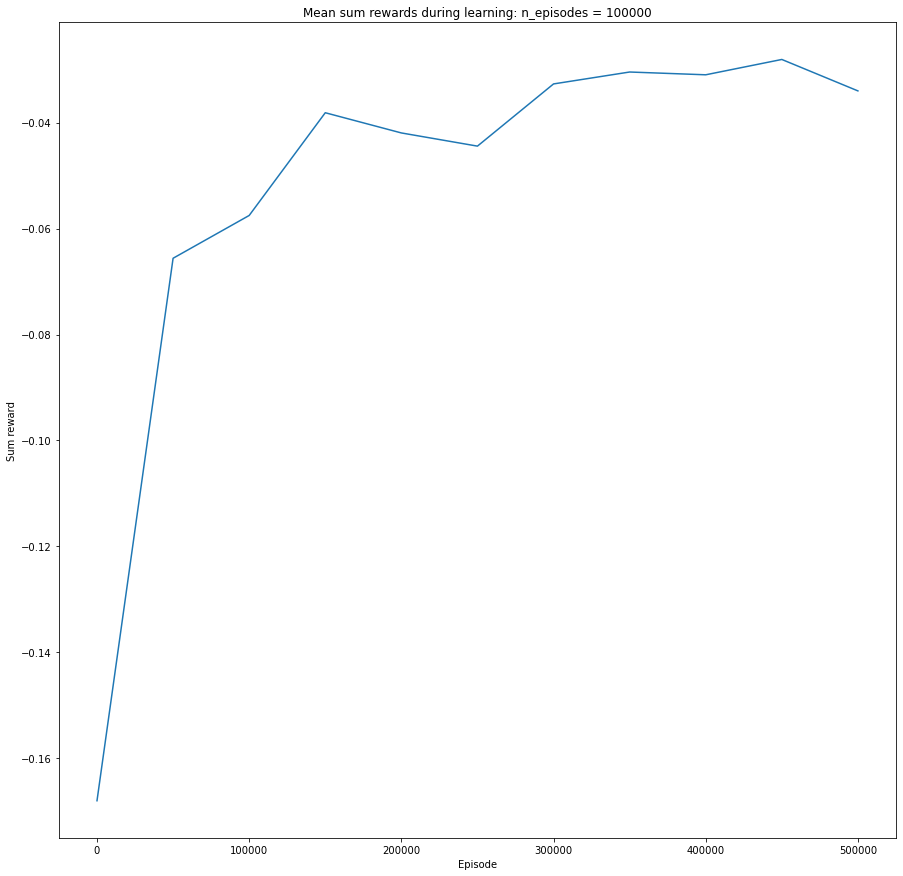

In [20]:
plot_sum_reward(sum_rewards)

# Часть вторая

## 4.
Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

## 5.
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

In [21]:
env_actions = {0: "Stick", 1: "Hit", 2: "Double"}
def make_step(env, action):
    if action == 0 or action == 1:
        next_state, reward, done, info = env.step(action)
    elif action == 2:
        # сначала берем карту, а потом прекращаем игру (удваиваем награду)
        next_state, reward, done, info = env.step(1)
        next_state, reward, done, info = env.step(0)
        reward *= 2
    else:
        raise Exception("Unknown action")
    return next_state, reward, done, info

In [27]:
policy, Q, sum_rewards = mc_control(env, 1000000, alpha=0.003, gamma=0.99995, eps_start=1.0, eps_decay=.99999, eps_min=0.02, 
                                    n_episodes=100000)

Episode = 1 Epsilon = 0.99999 Mean_sum_reward = -0.170215 n_episode = 100000
Episode = 100000 Epsilon = 0.3678776017682482 Mean_sum_reward = -0.05263 n_episode = 100000
Episode = 200000 Epsilon = 0.13533392988275578 Mean_sum_reward = -0.046885 n_episode = 100000
Episode = 300000 Epsilon = 0.04978632156314083 Mean_sum_reward = -0.034745 n_episode = 100000
Episode = 400000 Epsilon = 0.02 Mean_sum_reward = -0.02248 n_episode = 100000
Episode = 500000 Epsilon = 0.02 Mean_sum_reward = -0.023345 n_episode = 100000
Episode = 600000 Epsilon = 0.02 Mean_sum_reward = -0.024375 n_episode = 100000
Episode = 700000 Epsilon = 0.02 Mean_sum_reward = -0.02192 n_episode = 100000
Episode = 800000 Epsilon = 0.02 Mean_sum_reward = -0.00772 n_episode = 100000
Episode = 900000 Epsilon = 0.02 Mean_sum_reward = -0.014975 n_episode = 100000
Episode = 1000000 Epsilon = 0.02 Mean_sum_reward = -0.01081 n_episode = 100000




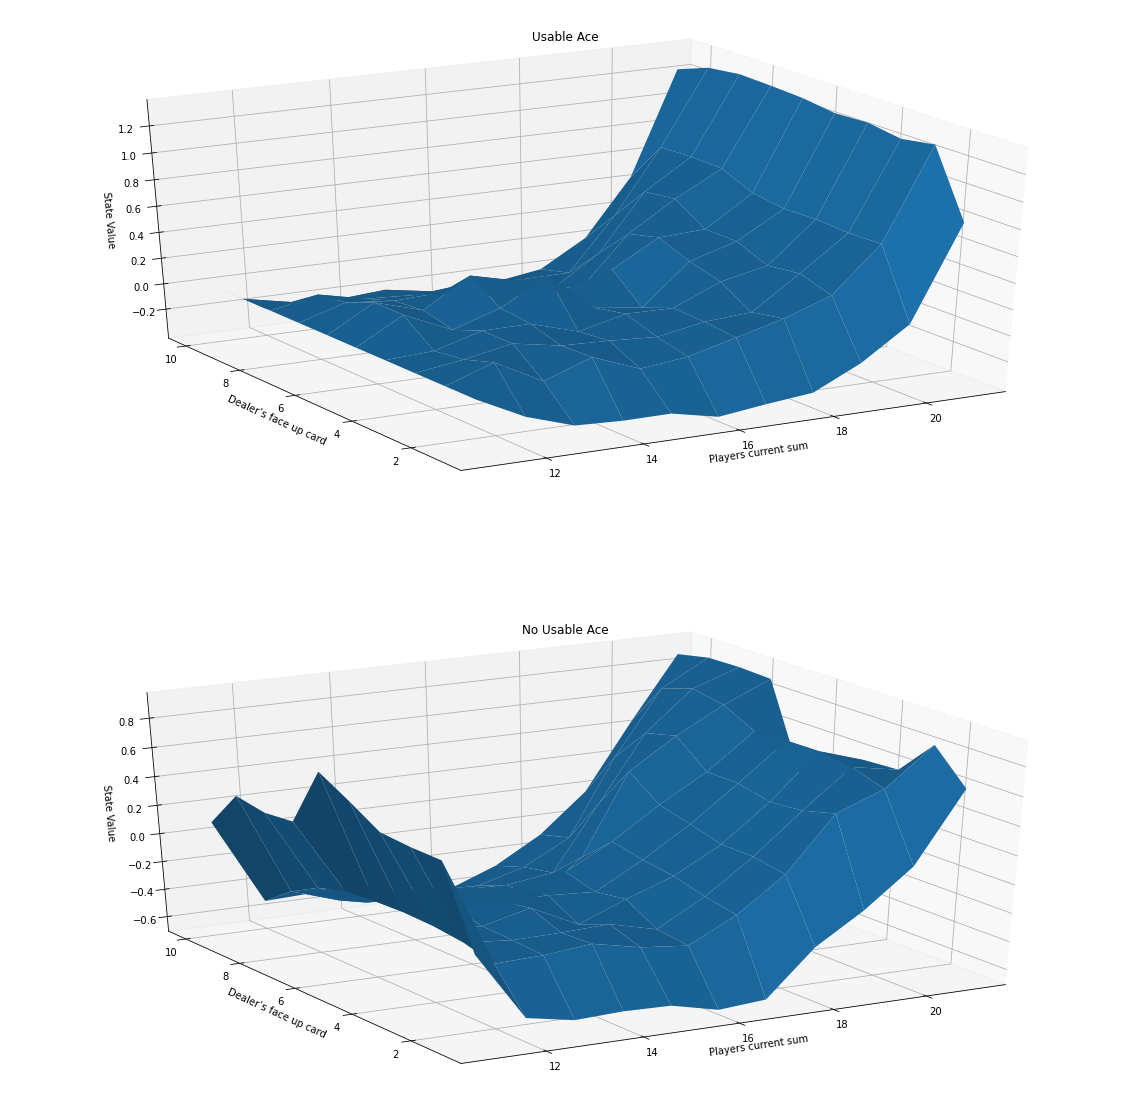

In [32]:
# V(s) = Q(s, π(s))
V = defaultdict(lambda:0, dict((k, np.max(v)) for k, v in Q.items()))

plot_V_function(V)

Сыграем 100000 эпизодов игры и посмотрим на средний выигрыш

In [33]:
play_n_episodes(episode_generator=lambda:generate_episode_from_Q(env, Q, epsilon=0.0, only_reward=True), n_episodes=100000)

(-0.01764, 100000)

Визуализируем полученную стратегию

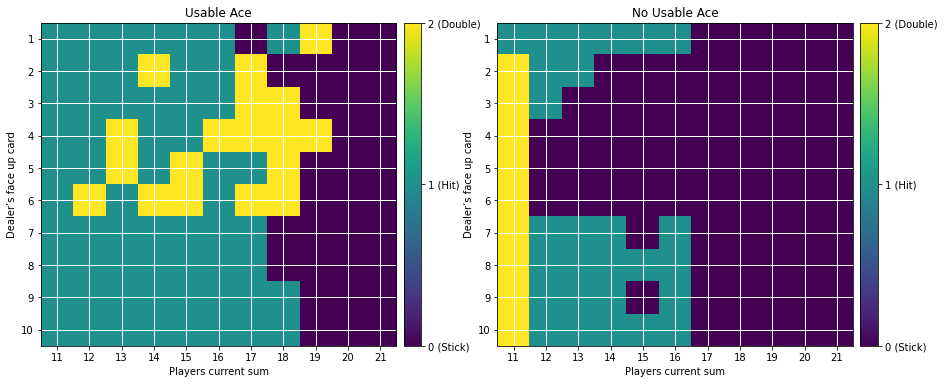

In [34]:
plot_policy(policy)

Визуализируем доходность стратегии в ходе обучения

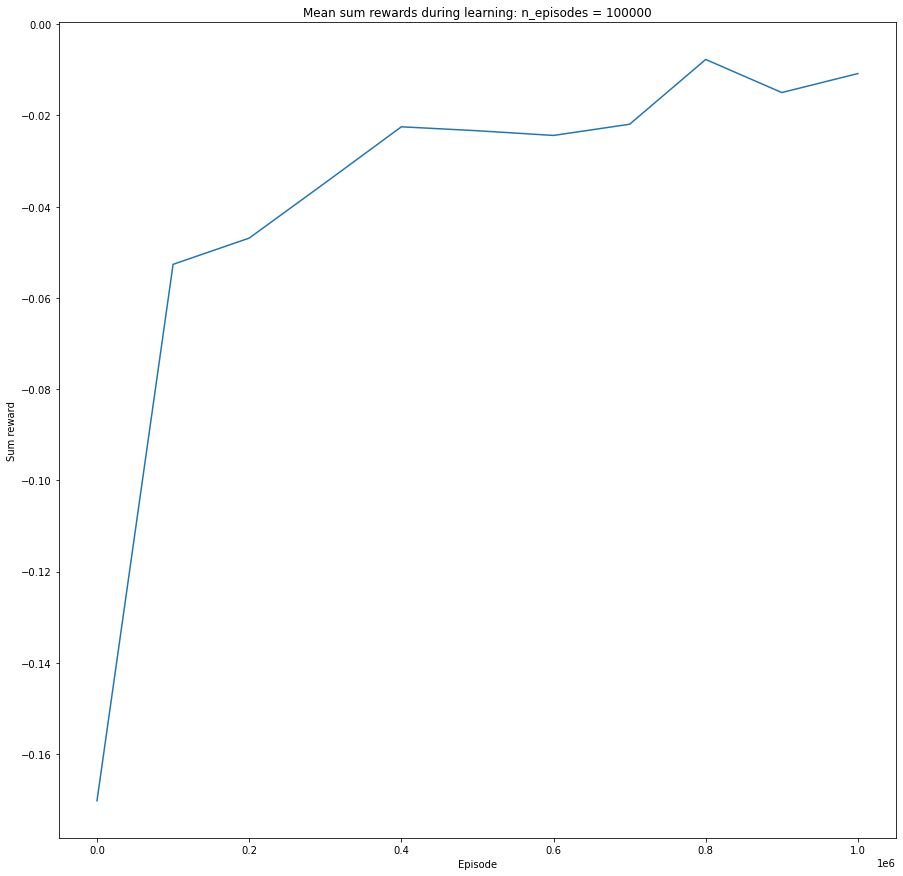

In [35]:
plot_sum_reward(sum_rewards)

# Часть третья

## 6.
Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Считаем, что игрок всегда следит за игрой с самого начала, поэтому он всегда знает, какие карты уже вылетели.

Считаем, что игрок играет один против дилера.

In [36]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def get_score(cards):
    card_to_score = {1:-1, 2:0.5, 3:1, 4:1, 5:1.5, 6:1, 7:0.5, 8:0, 9:-0.5, 10:-1}
    score = 0
    for card in cards:
        score += int(2 * card_to_score[card])
    return score


def draw_card(deck, score):
    card = deck[0]
    cards_score = get_score([card])
    score = score + cards_score
    deck = deck[1:]
    return card, deck, score


def draw_hand(deck, score):
    hand = deck[:2]
    hand_score = get_score(hand)
    score = score + hand_score
    deck = deck[2:]
    return hand, deck, score


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class Blackjack2Env(gym.Env):
    """
    Модернизированная версия бэкджека из библиотеки gym, в которой реализован подсчет методом "Половинки".
    
    Из википедии: "Система «Половинки», как и всякая сбалансированная система, обладает важным свойством: 
    при положительном счёте шансы игрока возрастают, при отрицательном — падают. Чем выше счёт, тем больше 
    ожидаемый выигрыш. Для определения суммы ставки используют не текущий счёт, а реальный счёт, который 
    получается в результате деления текущего счёта на число остающихся в игре колод. При всяком отклонении 
    счёта от нуля вероятности выхода карт изменяются и выгодно корректировать базовую стратегию. Чем выше
    реальный счёт, тем раньше надо останавливаться при наборе карт, чаще надо удваивать ставки или 
    разделять карты."
    
    Как считать:
        Карты       Числовые значения
        2           +0,5
        3,4         +1
        5           +1,5
        6           +1
        7           +0,5
        8           0
        9           −0,5
        10,В,Д,К,Т  −1

    Дополнительные состояния: 1) Текущий счет (21 значение) 2) Количество оставшихся карт (52 значения).
    
    Наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
    
    В планах: добавить новое действие - пропустить игру (в это время из колоды выкидывается от 4 до 10
    случайных карт).
    Но кажется, что агент в начале обучения будет слишком часто выбирать это действие, чтобы не проигрывать.
    И пока не понятно как это реализовать.
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(21),
            spaces.Discrete(52)
        ))
        self.deck = deck * 4  # в колоде по четыре карты
        self.seed()
        self.natural = natural
        self.deck = deck * 4  # в колоде по четыре карты
        random.shuffle(self.deck, self.np_random.random_sample)
        self.score = 0
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            card, self.deck, self.score = draw_card(self.deck, self.score)
            self.player.append(card)
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                card, self.deck, self.score = draw_card(self.deck, self.score)
                self.dealer.append(card)
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.score, len(self.deck))

    def reset(self):
        if len(self.deck) < 15:  # договорились что перемешиваем если в колоде меньше 15 карт
            self.deck = deck * 4  # в колоде по четыре карты
            random.shuffle(self.deck, self.np_random.random_sample)
            self.score = 0
        self.dealer, self.deck, self.score = draw_hand(self.deck, self.score)
        self.player, self.deck, self.score = draw_hand(self.deck, self.score)
        return self._get_obs()

In [37]:
env = Blackjack2Env(natural=True)

Не забудем про double

In [38]:
env_actions = {0: "Stick", 1: "Hit", 2: "Double"}
def make_step(env, action):
    if action == 0 or action == 1:
        next_state, reward, done, info = env.step(action)
    elif action == 2:
        # сначала берем карту, а потом прекращаем игру (удваиваем награду)
        next_state, reward, done, info = env.step(1)
        next_state, reward, done, info = env.step(0)
        reward *= 2
    else:
        raise Exception("Unknown action")
    return next_state, reward, done, info

In [39]:
for i in range(15):
    print(generate_episode_from_my_policy(env))

(((9, 10, False, -1, 44), (17, 10, False, -1, 43)), (1, 1), array([ 0., -1.]))
(((7, 10, False, -3, 38), (9, 10, False, -2, 37), (11, 10, False, -1, 36), (21, 10, False, -3, 35)), (1, 1, 1, 0), array([0., 0., 0., 1.]))
(((19, 10, False, -10, 31),), (0,), array([-1.]))
(((9, 8, False, -10, 27), (12, 8, False, -8, 26), (13, 8, False, -10, 25), (20, 8, False, -9, 24)), (1, 1, 1, 0), array([0., 0., 0., 1.]))
(((21, 10, True, -12, 20),), (0,), array([1.5]))
(((10, 5, False, -8, 15), (14, 5, False, -6, 14), (19, 5, False, -3, 13)), (1, 1, 0), array([0., 0., 0.]))
(((14, 10, False, -3, 48),), (1,), array([-1.]))
(((11, 1, False, 0, 43), (17, 1, False, 2, 42)), (1, 1), array([ 0., -1.]))
(((13, 2, False, -1, 37), (20, 2, False, 0, 36)), (1, 0), array([0., 0.]))
(((12, 10, False, -3, 31),), (1,), array([-1.]))
(((12, 8, False, -5, 26),), (1,), array([-1.]))
(((20, 10, False, -12, 21),), (0,), array([1.]))
(((13, 7, False, -7, 16), (17, 7, False, -5, 15), (20, 7, False, -3, 14)), (1, 1, 0), arra

In [46]:
policy, Q, sum_rewards = mc_control(env, 100000000, alpha=0.003, gamma=0.999999, eps_start=1.0, eps_decay=.999999, eps_min=0.05, 
                                    n_episodes=100000, verbose=10)

Episode = 1 Epsilon = 0.999999 Mean_sum_reward = -0.163875 n_episode = 100000
Episode = 10000000 Epsilon = 0.05 Mean_sum_reward = -0.101485 n_episode = 100000
Episode = 20000000 Epsilon = 0.05 Mean_sum_reward = -0.082985 n_episode = 100000
Episode = 30000000 Epsilon = 0.05 Mean_sum_reward = -0.066545 n_episode = 100000
Episode = 40000000 Epsilon = 0.05 Mean_sum_reward = -0.06182 n_episode = 100000
Episode = 50000000 Epsilon = 0.05 Mean_sum_reward = -0.05964 n_episode = 100000
Episode = 60000000 Epsilon = 0.05 Mean_sum_reward = -0.055405 n_episode = 100000
Episode = 70000000 Epsilon = 0.05 Mean_sum_reward = -0.04564 n_episode = 100000
Episode = 80000000 Epsilon = 0.05 Mean_sum_reward = -0.04529 n_episode = 100000
Episode = 90000000 Epsilon = 0.05 Mean_sum_reward = -0.0457 n_episode = 100000
Episode = 100000000 Epsilon = 0.05 Mean_sum_reward = -0.03846 n_episode = 100000




Сыграем 100000 эпизодов игры и посмотрим на средний выигрыш

In [47]:
play_n_episodes(episode_generator=lambda:generate_episode_from_Q(env, Q, epsilon=0.0, only_reward=True), n_episodes=100000)

(-0.03589, 100000)

Визуализируем доходность стратегии в ходе обучения

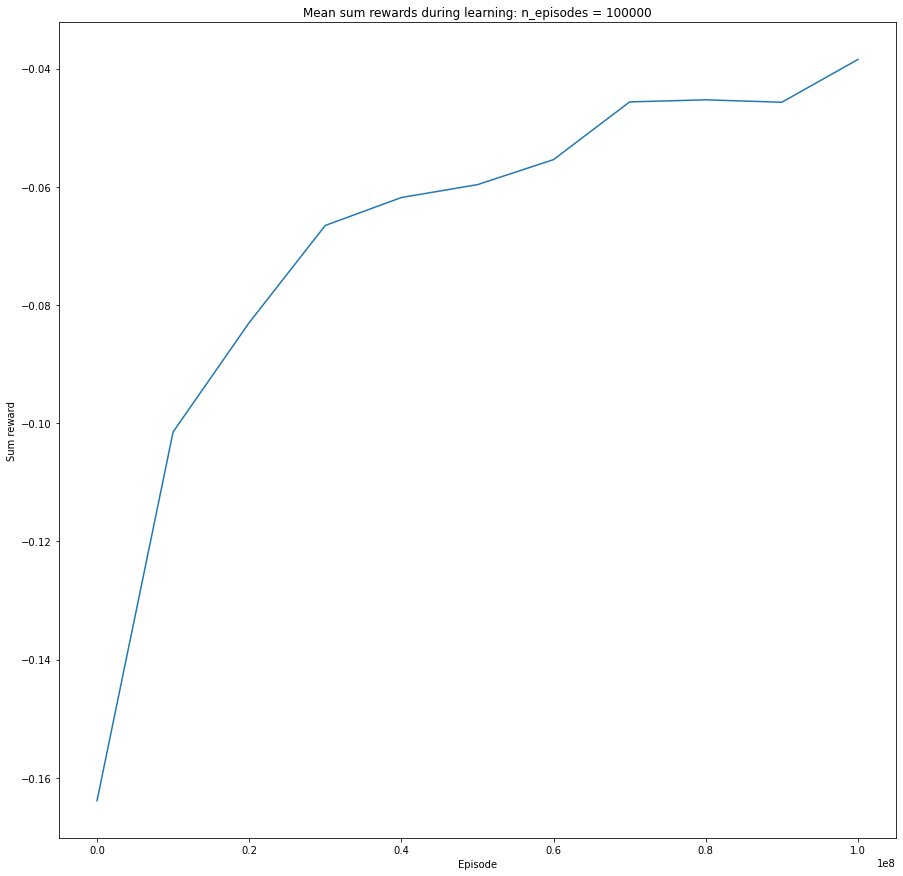

In [48]:
plot_sum_reward(sum_rewards)

Нужно дообучить

In [49]:
policy1, Q1, sum_rewards = mc_control(env, 100000000, alpha=0.03, init_Q=Q, gamma=1.0, eps_start=0.5, eps_decay=.99999995, eps_min=0.005, 
                                      n_episodes=100000, verbose=10)

Episode = 1 Epsilon = 0.499999975 Mean_sum_reward = -0.039985 n_episode = 100000
Episode = 10000000 Epsilon = 0.30326532597698075 Mean_sum_reward = -0.05331 n_episode = 100000
Episode = 20000000 Epsilon = 0.18393971587987276 Mean_sum_reward = -0.041115 n_episode = 100000
Episode = 30000000 Epsilon = 0.11156507579282549 Mean_sum_reward = -0.02305 n_episode = 100000
Episode = 40000000 Epsilon = 0.0676676381559068 Mean_sum_reward = -0.01587 n_episode = 100000
Episode = 50000000 Epsilon = 0.04104249668688136 Mean_sum_reward = -0.015275 n_episode = 100000
Episode = 60000000 Epsilon = 0.024893532273317694 Mean_sum_reward = -0.012325 n_episode = 100000
Episode = 70000000 Epsilon = 0.015098690359171964 Mean_sum_reward = -0.01329 n_episode = 100000
Episode = 80000000 Epsilon = 0.009157818507200958 Mean_sum_reward = -0.011785 n_episode = 100000
Episode = 90000000 Epsilon = 0.005554497629649445 Mean_sum_reward = -0.008655 n_episode = 100000
Episode = 100000000 Epsilon = 0.005 Mean_sum_reward = -0

Сыграем 100000 эпизодов игры и посмотрим на средний выигрыш

In [53]:
play_n_episodes(episode_generator=lambda:generate_episode_from_Q(env, Q1, epsilon=0.0, only_reward=True), n_episodes=100000)

(-0.011355, 100000)

Визуализируем доходность стратегии в ходе обучения

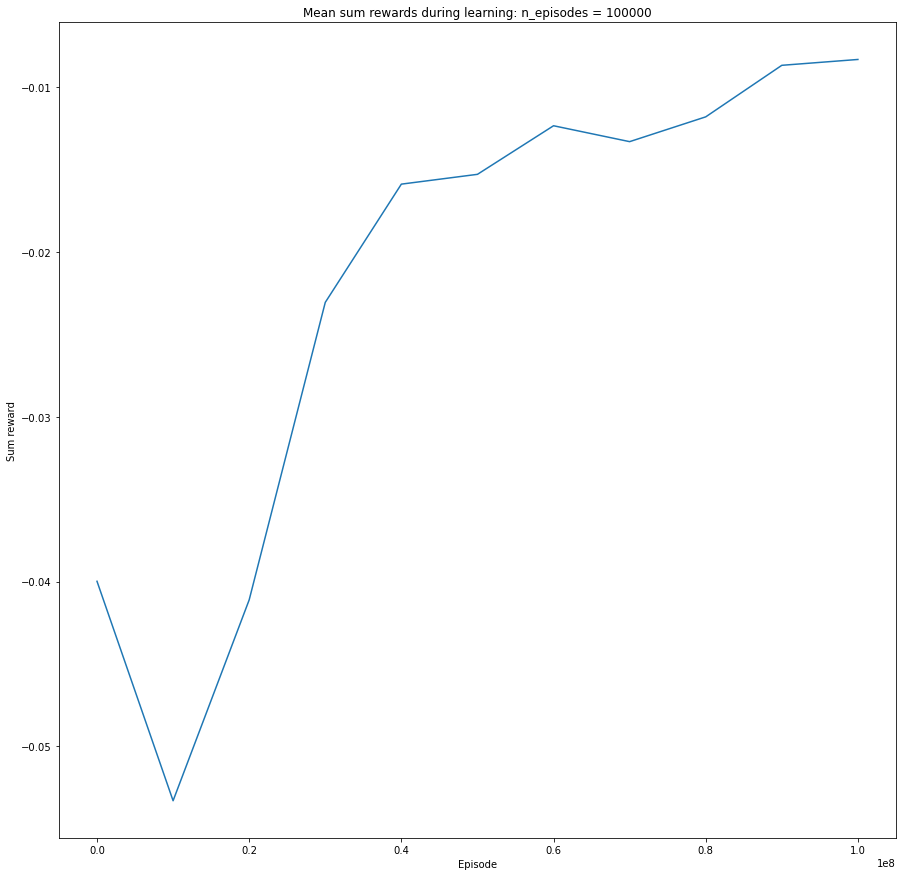

In [54]:
plot_sum_reward(sum_rewards)

Нужно дообучить

In [55]:
policy2, Q2, sum_rewards = mc_control(env, 50000000, alpha=0.001, init_Q=Q1, gamma=1.0, eps_start=0.1, eps_decay=.99999995, eps_min=0.005, 
                                      n_episodes=100000, verbose=10)

Episode = 1 Epsilon = 0.09999999500000001 Mean_sum_reward = -0.006715 n_episode = 100000
Episode = 5000000 Epsilon = 0.07788007780902106 Mean_sum_reward = -0.008775 n_episode = 100000
Episode = 10000000 Epsilon = 0.0606530651953819 Mean_sum_reward = -0.00936 n_episode = 100000
Episode = 15000000 Epsilon = 0.04723665436771852 Mean_sum_reward = -0.015405 n_episode = 100000
Episode = 20000000 Epsilon = 0.03678794317595932 Mean_sum_reward = -0.00661 n_episode = 100000
Episode = 25000000 Epsilon = 0.02865047876977666 Mean_sum_reward = -0.00686 n_episode = 100000
Episode = 30000000 Epsilon = 0.022313015158557468 Mean_sum_reward = -0.00519 n_episode = 100000
Episode = 35000000 Epsilon = 0.017377393567025345 Mean_sum_reward = -0.007405 n_episode = 100000
Episode = 40000000 Epsilon = 0.013533527631180264 Mean_sum_reward = -0.00724 n_episode = 100000
Episode = 45000000 Epsilon = 0.01053992184946974 Mean_sum_reward = -0.012425 n_episode = 100000
Episode = 50000000 Epsilon = 0.008208499337377557 M

In [56]:
play_n_episodes(episode_generator=lambda:generate_episode_from_Q(env, Q2, epsilon=0.0, only_reward=True), n_episodes=100000)

(-0.00753, 100000)

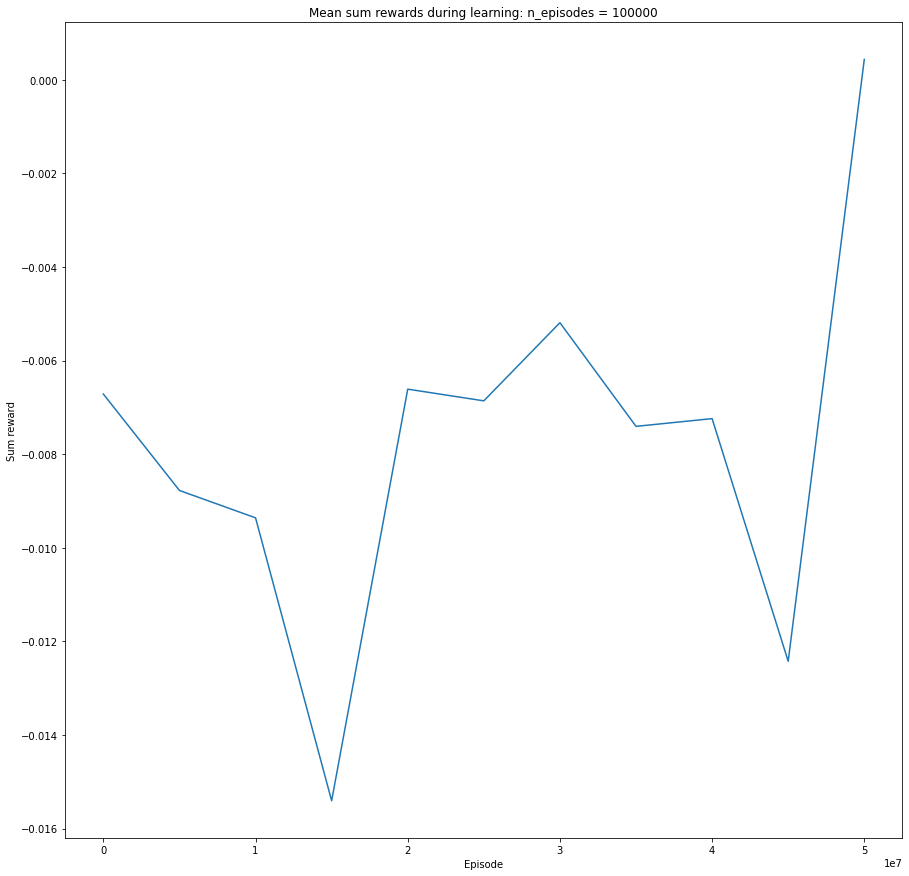

In [57]:
plot_sum_reward(sum_rewards)

# Вывод
Выиграть так и не получилось, только выйти почти в ноль. Делал несколько попыток дообучить, но все они только ухудшали текущий результат.